## Import libraries

In [1]:
import os
from Bio import SearchIO
from Bio.SearchIO import HmmerIO
from Bio import SeqIO
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 7.0)

import math
import numpy as np
#seed = 1337
seed = 42
np.random.seed(seed)
# THEANO_FLAGS="dnn.conv.algo_bwd_filter=deterministic, dnn.conv.algo_bwd_data=deterministic"

# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (10.0, 7.0)

#import numpy as np
#import matplotlib.pyplot as plt
import os
import pandas as pd
from collections import defaultdict
from Bio import SeqIO
from nltk import bigrams
from nltk import trigrams
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# import theano
# theano.config.device = 'gpu'
# theano.config.floatX = 'float32'
from keras.layers import Dropout
from keras.layers import Input, Dense, Lambda, LSTM, RepeatVector, Conv1D, MaxPooling1D, UpSampling1D
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras import regularizers
from keras.layers import GaussianNoise
from keras.layers import Activation
from keras.callbacks import LearningRateScheduler, EarlyStopping

from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras import regularizers
#from keras.regularizers import l2, activity_l2, l1, activity_l1
from keras.optimizers import Adam, SGD

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


import dask.dataframe as dd
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from scipy import interp
from itertools import cycle
from scipy import stats

import subprocess
from Bio.Blast import NCBIXML
from collections import defaultdict

/home/nafizh/anaconda3/lib/python3.6/site-packages/Bio/SearchIO/__init__.py:211: BiopythonExperimentalWarning: Bio.SearchIO is an experimental submodule which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning)
/home/nafizh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/nafizh/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Blast results

In [3]:
decoy_train = np.random.random((692, 3))
y = np.vstack((np.ones((346, 1)), 
                    np.zeros((346,1))))

## e-value

In [73]:
random_seed_list = [3,13,23,33,43,53,63,73,83,93]
precision_scores_mean_list = []
recall_scores_mean_list = []
f1_scores_mean_list = []

for rand_seed_num, rand_seed_i in enumerate(random_seed_list):
    precision_l = []
    recall_l = []
    f1_l = []
    cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = random_seed_list[rand_seed_num])
    for fold_num, (train_idx, test_idx) in enumerate(cv_outer.split(decoy_train, y)):
        with open('second_bacteriocin_training_set', 'r') as in_handle:
            out_training_handle = open('fold_num_%s_train_set.fa' % str(fold_num), 'w')
            out_test_handle = open('fold_num_%s_test_set.fa' % str(fold_num), 'w')

            for index, record in enumerate(SeqIO.parse(in_handle, 'fasta')):
                if index in train_idx and index <= 345:
                    out_training_handle.write('>%s\n%s\n' % (record.description, record.seq))
                if index in test_idx:
                    out_test_handle.write('>%s\n%s\n' % (record.description, record.seq))
            out_training_handle.close()
            out_test_handle.close()
            make_blastdb_command = ['makeblastdb', '-in', 'fold_num_%s_train_set.fa' % str(fold_num),  
                                    '-dbtype', 'prot', '-out', 'fold_num_%s_train_set_db' % str(fold_num)]
            proc = subprocess.call(make_blastdb_command)
            if proc != 0:
                print ("Error in make blast %s" % str(fold_num))

            subprocess.check_call(make_blastdb_command)

            blast_cmd = ['blastp', '-db', 'fold_num_%s_train_set_db' % str(fold_num), '-query', 
                         'fold_num_%s_test_set.fa' % str(fold_num), '-out', 'fold_num_%s_result.xml' % str(fold_num),
                         '-outfmt', '5', '-num_threads', '7']
            proc = subprocess.call(blast_cmd)
            if proc != 0:
                print ("Error in blast %s" % str(fold_num))

            result_handle = open("fold_num_%s_result.xml" % str(fold_num), 'r')
            blast_records = NCBIXML.parse(result_handle)
            scores = []
            # blast_records = number of sequences in query
            for i, blast_record in enumerate(blast_records):
                flag = 0
                # alignments = sequences in database
                for j, alignment in enumerate(blast_record.alignments): 
                    for hsp in alignment.hsps:
                        if hsp.expect < 0.001: # less than 10^-3
                            scores.append(1)
                            flag = 1
                            break
                    if flag == 1:
                        break
                if flag == 0:
                    scores.append(0)

            precision_s = precision_score(y[test_idx], scores)
            recall_s = recall_score(y[test_idx], scores)
            f1_s = f1_score(y[test_idx], scores)

            precision_l.append(precision_s)
            recall_l.append(recall_s)
            f1_l.append(f1_s)
            
    print("Finished Iter %s" % str(rand_seed_num))
    precision_scores_mean_list.append(np.mean(precision_l))
    recall_scores_mean_list.append(np.mean(recall_l))
    f1_scores_mean_list.append(np.mean(f1_l))
    
    rem_files = ['rm', 'fold_num_*']
    subprocess.call(rem_files)
    
    
                
#     print (train_idx)
#     print (test_idx)
#    break

Finished Iter 0
Finished Iter 1
Finished Iter 2
Finished Iter 3
Finished Iter 4
Finished Iter 5
Finished Iter 6
Finished Iter 7
Finished Iter 8
Finished Iter 9


In [75]:
"""
Result for 10 random seeds
"""
print (np.mean(precision_scores_mean_list), stats.sem(precision_scores_mean_list))
print (np.mean(recall_scores_mean_list), stats.sem(recall_scores_mean_list))
print (np.mean(f1_scores_mean_list), stats.sem(f1_scores_mean_list))
print (precision_scores_mean_list)
print (recall_scores_mean_list)
print (f1_scores_mean_list)


0.996592341358 4.82384902929e-05
0.846453781513 0.00138227844128
0.914424892143 0.000839305093982
[0.99677419354838714, 0.99655172413793092, 0.9966666666666667, 0.99642857142857155, 0.99655172413793092, 0.99642857142857155, 0.99687499999999996, 0.99642857142857155, 0.9966666666666667, 0.99655172413793092]
[0.85546218487394954, 0.84663865546218486, 0.84932773109243698, 0.84680672268907564, 0.84428571428571431, 0.84672268907563031, 0.84672268907563009, 0.84672268907563031, 0.8380672268907563, 0.84378151260504208]
[0.91939339053782165, 0.91513151868317644, 0.91652738364313302, 0.91507621953814444, 0.91299387714409386, 0.91469797725545199, 0.91410501997057525, 0.91476358514691114, 0.90928687021253629, 0.91227307930287815]


In [70]:
"""
10^-3, second negative set 
"""
print (np.mean(precision_l))
print (np.mean(recall_l))
print (np.mean(f1_l))

0.996551724138
0.844285714286
0.912993877144


In [68]:
"""
10^-6, primary negative set 
"""
print (np.mean(precision_l))
print (np.mean(recall_l))
print (np.mean(f1_l))

0.996666666667
0.754537815126
0.857488500843


In [66]:
#(y[test_idx] == scores)
#y[test_idx][y[test_idx] == 1].shape
#y[test_idx]
print(scores)

[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [54]:
print (precision_l)
print (recall_l)

[0.96969696969696972, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96969696969696972, 1.0, 1.0]
[0.91428571428571426, 0.8571428571428571, 0.8571428571428571, 0.77142857142857146, 0.77142857142857146, 0.77142857142857146, 0.91176470588235292, 0.94117647058823528, 0.82352941176470584, 0.82352941176470584]


In [42]:
result_handle = open("fold_num_0_result.xml", 'r')
blast_records = NCBIXML.parse(result_handle)
scores = []
# blast_records = number of sequences in query
for i, blast_record in enumerate(blast_records):
    flag = 0
    for j, alignment in enumerate(blast_record.alignments): # alignment = Hit_num in blast result
        for hsp in alignment.hsps:
            if hsp.expect < 0.001: # less than 10^-3
                scores.append(1)
                flag = 1
                break
        if flag == 1:
            break
    if flag == 0:
        scores.append(0)
print (len(scores))

70


In [34]:
result_handle = open("fold_num_0_result.xml", 'r')
blast_records = NCBIXML.parse(result_handle)
temp = [i for i, blast_record in enumerate(blast_records)]
print (len(temp))
print (scores)

70
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [40]:
h = y[test_idx]
len(h[h==1])

35

In [36]:
precision_s = precision_score(y[test_idx], scores)
recall_s = recall_score(y[test_idx], scores)
f1_s = f1_score(y[test_idx], scores)
print (precision_s)
print (recall_s)
print (f1_s)

0.969696969697
0.914285714286
0.941176470588


## identity-score

In [15]:
random_seed_list = [3,13,23,33,43,53,63,73,83,93]
precision_scores_mean_list = []
recall_scores_mean_list = []
f1_scores_mean_list = []

for rand_seed_num, rand_seed_i in enumerate(random_seed_list):
    precision_l = []
    recall_l = []
    f1_l = []
    cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = random_seed_list[rand_seed_num])
    for fold_num, (train_idx, test_idx) in enumerate(cv_outer.split(decoy_train, y)):
        with open('third_bacteriocin_training_set', 'r') as in_handle:
            out_training_handle = open('fold_num_%s_train_set.fa' % str(fold_num), 'w')
            out_test_handle = open('fold_num_%s_test_set.fa' % str(fold_num), 'w')

            for index, record in enumerate(SeqIO.parse(in_handle, 'fasta')):
                if index in train_idx:
                    out_training_handle.write('>%s\n%s\n' % (record.description, record.seq))
                if index in test_idx:
                    out_test_handle.write('>%s\n%s\n' % (record.description, record.seq))
            out_training_handle.close()
            out_test_handle.close()
            make_blastdb_command = ['makeblastdb', '-in', 'fold_num_%s_train_set.fa' % str(fold_num),  
                                    '-dbtype', 'prot', '-out', 'fold_num_%s_train_set_db' % str(fold_num)]
            proc = subprocess.call(make_blastdb_command)
            if proc != 0:
                print ("Error in make blast %s" % str(fold_num))

            subprocess.check_call(make_blastdb_command)

            blast_cmd = ['blastp', '-db', 'fold_num_%s_train_set_db' % str(fold_num), '-query', 
                         'fold_num_%s_test_set.fa' % str(fold_num), '-out', 'fold_num_%s_result.xml' % str(fold_num),
                         '-outfmt', '5', '-num_threads', '7']
            proc = subprocess.call(blast_cmd)
            if proc != 0:
                print ("Error in blast %s" % str(fold_num))

            result_handle = open("fold_num_%s_result.xml" % str(fold_num), 'r')
            blast_records = NCBIXML.parse(result_handle)
            
            
            probas_ = []
        
            for i, blast_record in enumerate(blast_records):
                identity = []
                #flag = 0
                # alignments = sequences in database
                for j, alignment in enumerate(blast_record.alignments): 
                    for hsp in alignment.hsps:
                        #print (hsp.identities)
                        identity.append(hsp.identities)
                #print (identity)
                if identity == []:
                    probas_.append(0)
                else:
                    probas_.append(max(identity))
                
            probas_ = [num / 100.0 for num in probas_]
            probas_ = np.asarray(probas_)
            #print(probas_)
            scores = np.where(probas_ > 0.35, 1, 0)
            scores = np.asarray(scores)
            #print(scores)
            precision_s = precision_score(y[test_idx], scores)
            recall_s = recall_score(y[test_idx], scores)
            f1_s = f1_score(y[test_idx], scores)

            precision_l.append(precision_s)
            recall_l.append(recall_s)
            f1_l.append(f1_s)
            
    print("Finished Iter %s" % str(rand_seed_num))
    precision_scores_mean_list.append(np.mean(precision_l))
    recall_scores_mean_list.append(np.mean(recall_l))
    f1_scores_mean_list.append(np.mean(f1_l))
    
    rem_files = ['rm', 'fold_num_*']
    proc = subprocess.call('rm fold_num_*', shell=True)
    if proc != 0:
        print ("Error in removing files")
    
    
                
#     print (train_idx)
#     print (test_idx)
#    break

Finished Iter 0
Finished Iter 1
Finished Iter 2
Finished Iter 3
Finished Iter 4
Finished Iter 5
Finished Iter 6
Finished Iter 7
Finished Iter 8
Finished Iter 9


In [11]:
"""
Result for 10 random seeds - primary neg
"""
print (np.mean(precision_scores_mean_list), stats.sem(precision_scores_mean_list))
print (np.mean(recall_scores_mean_list), stats.sem(recall_scores_mean_list))
print (np.mean(f1_scores_mean_list), stats.sem(f1_scores_mean_list))
print (precision_scores_mean_list)
print (recall_scores_mean_list)
print (f1_scores_mean_list)

0.9729977733413595 0.0006479026254035766
0.506983193277311 0.002581394734023158
0.6632197701552881 0.0020727627517767035
[0.9743108837737994, 0.9744338118022329, 0.9744486215538846, 0.9706057422969188, 0.9745066630771302, 0.9720489336085312, 0.9764285714285714, 0.9709868421052631, 0.9711309523809524, 0.971076711386309]
[0.5146218487394958, 0.5058823529411764, 0.5085714285714286, 0.516470588235294, 0.5092436974789916, 0.5116806722689076, 0.5030252100840336, 0.5000840336134453, 0.5115966386554622, 0.4886554621848739]
[0.6704027404408228, 0.6630523378502692, 0.664202141436184, 0.6714355907874185, 0.6615915846338607, 0.6697866568010852, 0.6600283658009577, 0.6587538318958963, 0.6635298413597006, 0.649414610546686]


In [14]:
"""
Result for 10 random seeds - second neg
"""
print (np.mean(precision_scores_mean_list), stats.sem(precision_scores_mean_list))
print (np.mean(recall_scores_mean_list), stats.sem(recall_scores_mean_list))
print (np.mean(f1_scores_mean_list), stats.sem(f1_scores_mean_list))
print (precision_scores_mean_list)
print (recall_scores_mean_list)
print (f1_scores_mean_list)

0.9093325712456283 0.0024399040434849094
0.5043697478991597 0.0025470180216625904
0.6452384866728698 0.00181340493793003
[0.9083835569315445, 0.8977741702741703, 0.9014636929940133, 0.9124640637140636, 0.911338164908632, 0.9074713958810069, 0.9254588744588744, 0.9078427569349632, 0.9052372234935164, 0.9158918128654971]
[0.5116806722689076, 0.5030252100840336, 0.5056302521008403, 0.5135294117647058, 0.5063865546218487, 0.5087394957983193, 0.5030252100840336, 0.49722689075630255, 0.5087394957983193, 0.48571428571428565]
[0.6518265748804322, 0.6432711705608487, 0.6448551642988026, 0.6525940175704306, 0.6456696159159214, 0.6503391411633715, 0.6468224441969823, 0.639281409636073, 0.6438091227072763, 0.6339162057985588]


In [16]:
"""
Result for 10 random seeds - third neg
"""
print (np.mean(precision_scores_mean_list), stats.sem(precision_scores_mean_list))
print (np.mean(recall_scores_mean_list), stats.sem(recall_scores_mean_list))
print (np.mean(f1_scores_mean_list), stats.sem(f1_scores_mean_list))
print (precision_scores_mean_list)
print (recall_scores_mean_list)
print (f1_scores_mean_list)

0.7473116238652409 0.004302423268586996
0.5043697478991597 0.0025470180216625904
0.5992339463448919 0.0024389841407542125
[0.7787829175006594, 0.7322616323417239, 0.7450350874623739, 0.7561662263303154, 0.7333349399138871, 0.753010257858084, 0.7473328614396725, 0.7358584214386313, 0.7449470081792597, 0.7463868861878015]
[0.5116806722689076, 0.5030252100840336, 0.5056302521008403, 0.5135294117647058, 0.5063865546218487, 0.5087394957983193, 0.5030252100840336, 0.49722689075630255, 0.5087394957983193, 0.48571428571428565]
[0.6127362564820077, 0.5948400962621542, 0.5980132572040315, 0.6076345897425045, 0.596258424701477, 0.6066817687116681, 0.5969063991486887, 0.5919493939007764, 0.5998542717488438, 0.5874650055467675]


In [4]:
cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 43)

thresholds_c = []
precision_c = []
recall_c = []
for fold_num, (train_idx, test_idx) in enumerate(cv_outer.split(decoy_train, y)):
    with open('second_bacteriocin_training_set', 'r') as in_handle:
        out_training_handle = open('fold_num_%s_train_set.fa' % str(fold_num), 'w')
        out_test_handle = open('fold_num_%s_test_set.fa' % str(fold_num), 'w')

        for index, record in enumerate(SeqIO.parse(in_handle, 'fasta')):
            if index in train_idx and index <= 345:
                out_training_handle.write('>%s\n%s\n' % (record.description, record.seq))
            if index in test_idx:
                out_test_handle.write('>%s\n%s\n' % (record.description, record.seq))
        out_training_handle.close()
        out_test_handle.close()
        make_blastdb_command = ['makeblastdb', '-in', 'fold_num_%s_train_set.fa' % str(fold_num),  
                                '-dbtype', 'prot', '-out', 'fold_num_%s_train_set_db' % str(fold_num)]
        proc = subprocess.call(make_blastdb_command)
        if proc != 0:
            print ("Error in make blast %s" % str(fold_num))

        subprocess.check_call(make_blastdb_command)

        blast_cmd = ['blastp', '-db', 'fold_num_%s_train_set_db' % str(fold_num), '-query', 
                     'fold_num_%s_test_set.fa' % str(fold_num), '-out', 'fold_num_%s_result.xml' % str(fold_num),
                     '-outfmt', '5', '-num_threads', '7']
        proc = subprocess.call(blast_cmd)
        if proc != 0:
            print ("Error in blast %s" % str(fold_num))

        result_handle = open("fold_num_%s_result.xml" % str(fold_num), 'r')
        blast_records = NCBIXML.parse(result_handle)
        #scores = []
        # blast_records = number of sequences in query
        
        probas_ = []
        
        for i, blast_record in enumerate(blast_records):
            identity = []
            #flag = 0
            # alignments = sequences in database
            for j, alignment in enumerate(blast_record.alignments): 
                for hsp in alignment.hsps:
                    #print (hsp.identities)
                    identity.append(hsp.identities)
            #print (identity)
            if identity == []:
                probas_.append(0)
            else:
                probas_.append(max(identity))

#         precision_s = precision_score(y[test_idx], scores)
#         recall_s = recall_score(y[test_idx], scores)
#         f1_s = f1_score(y[test_idx], scores)
        precision, recall, thresholds = precision_recall_curve(y[test_idx], probas_)
        thresholds_c.append(thresholds)
        precision_c.append(precision)
        recall_.append(recall)
        #f1_l.append(f1_s)

    print("Finished fold %s" % str(fold_num))
#    break

Finished fold 0
Finished fold 1
Finished fold 2
Finished fold 3
Finished fold 4
Finished fold 5
Finished fold 6
Finished fold 7
Finished fold 8
Finished fold 9


In [92]:
print (probas_)

[41, 26, 23, 31, 22, 56, 17, 20, 26, 45, 20, 51, 26, 46, 66, 66, 31, 77, 20, 9, 64, 56, 15, 50, 27, 37, 32, 19, 36, 59, 42, 43, 24, 61, 36, 11, 12, 8, 6, 12, 8, 10, 12, 7, 8, 6, 11, 8, 11, 8, 10, 8, 8, 5, 6, 8, 10, 5, 8, 6, 8, 5, 5, 10, 7]


In [5]:
print (len(precision_c))
print (len(recall_c))
print (len(thresholds_c))

10
10
10


## 10-fold pr-curve

Finished fold 0
Finished fold 1
Finished fold 2
Finished fold 3
Finished fold 4
Finished fold 5
Finished fold 6
Finished fold 7
Finished fold 8
Finished fold 9


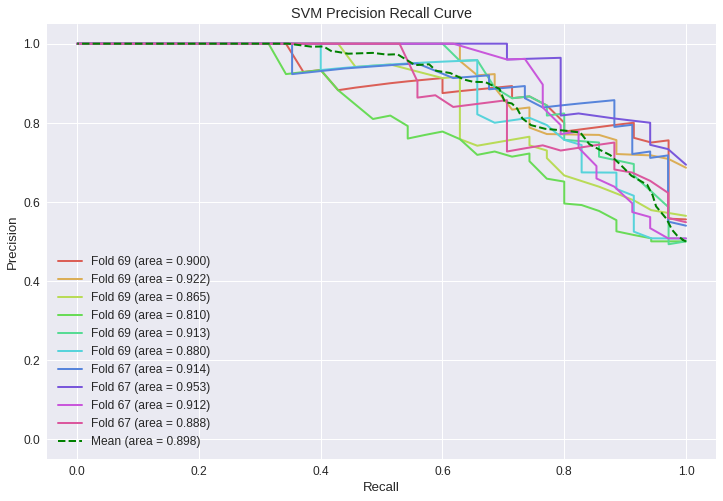

In [6]:
import seaborn as sns
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
               'deepskyblue', 'lightcoral'])

sns.set(font_scale = 1.2)
colors = sns.hls_palette(10)
fig, ax = plt.subplots()
fig.set_size_inches(12.0, 8.0)

lw = 2
i = 0

cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 43)


precision_l = []
recall_l = []
f1_l = []

y_real = []
y_proba = []
precision_blast = []
recall_blast = []
threshold_blast = []

for fold_num, ((train_idx, test_idx), color) in enumerate(zip(cv_outer.split(decoy_train, y), colors)):
    with open('primary_bacteriocin_training_set', 'r') as in_handle:
        out_training_handle = open('fold_num_%s_train_set.fa' % str(fold_num), 'w')
        out_test_handle = open('fold_num_%s_test_set.fa' % str(fold_num), 'w')

        for index, record in enumerate(SeqIO.parse(in_handle, 'fasta')):
            #if index in train_idx and index <= 345:
            if index in train_idx:
                out_training_handle.write('>%s\n%s\n' % (record.description, record.seq))
            if index in test_idx:
                out_test_handle.write('>%s\n%s\n' % (record.description, record.seq))
        out_training_handle.close()
        out_test_handle.close()
        make_blastdb_command = ['makeblastdb', '-in', 'fold_num_%s_train_set.fa' % str(fold_num),  
                                '-dbtype', 'prot', '-out', 'fold_num_%s_train_set_db' % str(fold_num)]
        proc = subprocess.call(make_blastdb_command)
        if proc != 0:
            print ("Error in make blast %s" % str(fold_num))

        subprocess.check_call(make_blastdb_command)

        blast_cmd = ['blastp', '-db', 'fold_num_%s_train_set_db' % str(fold_num), '-query', 
                     'fold_num_%s_test_set.fa' % str(fold_num), '-out', 'fold_num_%s_result.xml' % str(fold_num),
                     '-outfmt', '5', '-num_threads', '7']
        proc = subprocess.call(blast_cmd)
        if proc != 0:
            print ("Error in blast %s" % str(fold_num))

        result_handle = open("fold_num_%s_result.xml" % str(fold_num), 'r')
        blast_records = NCBIXML.parse(result_handle)
        #scores = []
        # blast_records = number of sequences in query
        
        probas_ = []
        
        for i, blast_record in enumerate(blast_records):
            identity = []
            #flag = 0
            # alignments = sequences in database
            for j, alignment in enumerate(blast_record.alignments): 
                for hsp in alignment.hsps:
                    #print (hsp.identities)
                    identity.append(hsp.identities)
            #print (identity)
            if identity == []:
                probas_.append(0)
            else:
                probas_.append(max(identity))

        
        probas_ = [num / 100.0 for num in probas_]
        probas_ = np.asarray(probas_)
        #print(probas_)
        scores = np.where(probas_ > 0.35, 1, 0)
        scores = np.asarray(scores)
        #print(scores)
        #print(y[test_idx])
        precision_s = precision_score(y[test_idx], scores)
        recall_s = recall_score(y[test_idx], scores)
        f1_s = f1_score(y[test_idx], scores)
        
        precision_l.append(precision_s)
        recall_l.append(recall_s)
        f1_l.append(f1_s)
        
        precision, recall, thresholds = precision_recall_curve(y[test_idx], probas_)
        precision_blast.append(precision)
        recall_blast.append(recall)
        threshold_blast.append(thresholds)
        
        plt.plot(recall, precision, lw=lw, color=color,
             label='Fold %d (area = %0.3f)' % (i, auc(recall, precision)))
        y_real.append(y[test_idx])
        y_proba.append(probas_)
        i += 1
        
        rem_files = ['rm', 'fold_num_*']
        proc = subprocess.call('rm fold_num_*', shell=True)
        if proc != 0:
            print ("Error in removing files")
        

    print("Finished fold %s" % str(fold_num))
#    break
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, thresholds = precision_recall_curve(y_real, y_proba)
precision_blast.append(precision)
recall_blast.append(recall)
threshold_blast.append(thresholds)
plt.plot(recall, precision, lw=lw, color='g', linestyle='--',
             label='Mean (area = %0.3f)' % (auc(recall, precision)))

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('SVM Precision Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [7]:
# np.save('blast_precision_10_fold_seed_43.npy', precision_blast)
# np.save('blast_recall_10_fold_seed_43.npy', recall_blast)
# np.save('blast_threshold_10_fold_seed_43.npy', threshold_blast)

In [ ]:
import seaborn as sns
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
               'deepskyblue', 'lightcoral'])

sns.set(font_scale = 1.2)
colors = sns.hls_palette(10)
fig, ax = plt.subplots()
fig.set_size_inches(12.0, 8.0)

lw = 2
i = 0

cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 43)


precision_l = []
recall_l = []
f1_l = []

y_real = []
y_proba = []
precision_blast = []
recall_blast = []
threshold_blast = []

for fold_num, ((train_idx, test_idx), color) in enumerate(zip(cv_outer.split(decoy_train, y), colors)):
    with open('primary_bacteriocin_training_set', 'r') as in_handle:
        out_training_handle = open('fold_num_%s_train_set.fa' % str(fold_num), 'w')
        out_test_handle = open('fold_num_%s_test_set.fa' % str(fold_num), 'w')

        for index, record in enumerate(SeqIO.parse(in_handle, 'fasta')):
            #if index in train_idx and index <= 345:
            if index in train_idx:
                out_training_handle.write('>%s\n%s\n' % (record.description, record.seq))
            if index in test_idx:
                out_test_handle.write('>%s\n%s\n' % (record.description, record.seq))
        out_training_handle.close()
        out_test_handle.close()
        make_blastdb_command = ['makeblastdb', '-in', 'fold_num_%s_train_set.fa' % str(fold_num),  
                                '-dbtype', 'prot', '-out', 'fold_num_%s_train_set_db' % str(fold_num)]
        proc = subprocess.call(make_blastdb_command)
        if proc != 0:
            print ("Error in make blast %s" % str(fold_num))

        subprocess.check_call(make_blastdb_command)

        blast_cmd = ['blastp', '-db', 'fold_num_%s_train_set_db' % str(fold_num), '-query', 
                     'fold_num_%s_test_set.fa' % str(fold_num), '-out', 'fold_num_%s_result.xml' % str(fold_num),
                     '-outfmt', '5', '-num_threads', '7']
        proc = subprocess.call(blast_cmd)
        if proc != 0:
            print ("Error in blast %s" % str(fold_num))

        result_handle = open("fold_num_%s_result.xml" % str(fold_num), 'r')
        blast_records = NCBIXML.parse(result_handle)
        #scores = []
        # blast_records = number of sequences in query
        
        scores = []
        # blast_records = number of sequences in query
        for i, blast_record in enumerate(blast_records):
            flag = 0
            # alignments = sequences in database
            for j, alignment in enumerate(blast_record.alignments): 
                for hsp in alignment.hsps:
                    if hsp.expect < 0.001: # less than 10^-3
                        scores.append(1)
                        flag = 1
                        break
                if flag == 1:
                    break
            if flag == 0:
                scores.append(0)

        
        probas_ = [num / 100.0 for num in probas_]
        probas_ = np.asarray(probas_)
        #print(probas_)
        scores = np.where(probas_ > 0.35, 1, 0)
        scores = np.asarray(scores)
        #print(scores)
        #print(y[test_idx])
        precision_s = precision_score(y[test_idx], scores)
        recall_s = recall_score(y[test_idx], scores)
        f1_s = f1_score(y[test_idx], scores)
        
        precision_l.append(precision_s)
        recall_l.append(recall_s)
        f1_l.append(f1_s)
        
        precision, recall, thresholds = precision_recall_curve(y[test_idx], probas_)
        precision_blast.append(precision)
        recall_blast.append(recall)
        threshold_blast.append(thresholds)
        
        plt.plot(recall, precision, lw=lw, color=color,
             label='Fold %d (area = %0.3f)' % (i, auc(recall, precision)))
        y_real.append(y[test_idx])
        y_proba.append(probas_)
        i += 1
        
        rem_files = ['rm', 'fold_num_*']
        proc = subprocess.call('rm fold_num_*', shell=True)
        if proc != 0:
            print ("Error in removing files")
        

    print("Finished fold %s" % str(fold_num))
#    break
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, thresholds = precision_recall_curve(y_real, y_proba)
precision_blast.append(precision)
recall_blast.append(recall)
threshold_blast.append(thresholds)
plt.plot(recall, precision, lw=lw, color='g', linestyle='--',
             label='Mean (area = %0.3f)' % (auc(recall, precision)))

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('SVM Precision Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [8]:
print (np.mean(precision_l))
print (np.mean(recall_l))
print (np.mean(f1_l))

0.9745066630771302
0.5092436974789916
0.6615915846338607


In [25]:
print (precision_l)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [21]:
print (len(probas_))
print (probas_)

68
[0.27, 0.08, 0.51, 0.13, 0.45, 0.2, 0.48, 0.28, 0.18, 0.68, 0.27, 0.66, 0.52, 0.62, 0.17, 0.43, 0.39, 0.33, 0.21, 0.3, 0.37, 0.41, 0.18, 0.11, 0.67, 0.59, 0.56, 0.11, 0.36, 0.19, 0.37, 0.52, 0.27, 0.34, 0.08, 0.08, 0.08, 0.09, 0.11, 0.1, 0.08, 0.13, 0.08, 0.21, 0.1, 0.0, 0.0, 0.0, 0.09, 0.0, 0.09, 0.0, 0.14, 0.09, 0.08, 0.07, 0.08, 0.06, 0.06, 0.1, 0.05, 0.06, 0.09, 0.14, 0.09, 0.1, 0.09, 0.09]


In [32]:
a = [1, 2]
a = np.asarray(a)
print(a)

[1 2]


## 10-fold ROC curve 

[1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 1 0 0 1
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0.41 0.26 0.23 0.31 0.22 0.56 0.17 0.2  0.26 0.45 0.2  0.51 0.26 0.46
 0.66 0.66 0.31 0.77 0.2  0.09 0.64 0.56 0.15 0.5  0.27 0.37 0.32 0.19
 0.36 0.59 0.42 0.43 0.24 0.61 0.36 0.25 0.41 0.3  0.1  0.12 0.13 0.1
 0.12 0.23 0.11 0.08 0.09 0.43 0.18 0.18 0.11 0.11 0.11 0.08 0.11 0.07
 0.06 0.14 0.12 0.22 0.22 0.17 0.08 0.12 0.21 0.   0.12 0.07 0.1  0.1 ]
Finished fold 0
[0 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0.3  0.49 0.41 0.25 0.14 0.19 0.19 0.56 0.52 0.59 0.44 0.47 0.5  0.59
 0.16 0.19 0.49 0.69 0.45 0.88 0.2  0.66 0.43 0.64 0.18 0.33 0.54 0.62
 0.43 0.16 0.15 0.89 0.96 0.6  0.24 0.36 0.09 0.33 0.09 0.08 0.27 0.18
 0.1  0.06 0.19 0.08 0.1  0.25 0.09 0.15 0.14 0.21 0.22 0.   0.06 0.09
 0.16 0.07 0.11 0.09 0.14 0.09 0.1  0.2  0.17 0.25 0.17 0.0

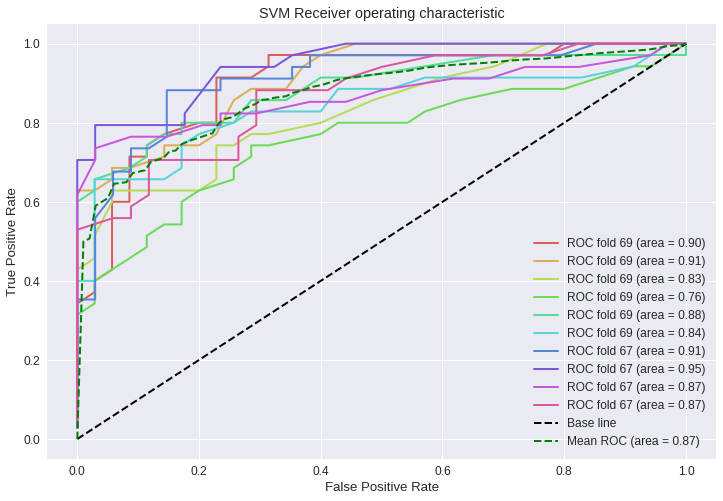

In [69]:
# ROC curve stuff
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
colors = cycle(['cyan', 'crimson', 'seagreen', 'yellow', 'blue', 'darkorange', 'darkviolet', 'fuchsia',
               'deepskyblue', 'lightcoral'])
lw = 2
i = 0

sns.set(font_scale = 1.2)
colors = sns.hls_palette(10)
fig, ax = plt.subplots()
fig.set_size_inches(12.0, 8.0)

precision_scores = []
recall_scores = []
f1_scores = []

fpr_svm = []
tpr_svm = []
threshold_roc_svm = []

cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 43)

thresholds_c = []
precision_c = []
recall_c = []
for fold_num, ((train_idx, test_idx), color) in enumerate(zip(cv_outer.split(decoy_train, y), colors)):
    with open('primary_bacteriocin_training_set', 'r') as in_handle:
        out_training_handle = open('fold_num_%s_train_set.fa' % str(fold_num), 'w')
        out_test_handle = open('fold_num_%s_test_set.fa' % str(fold_num), 'w')

        for index, record in enumerate(SeqIO.parse(in_handle, 'fasta')):
            #if index in train_idx and index <= 345:
            if index in train_idx:
                out_training_handle.write('>%s\n%s\n' % (record.description, record.seq))
            if index in test_idx:
                out_test_handle.write('>%s\n%s\n' % (record.description, record.seq))
        out_training_handle.close()
        out_test_handle.close()
        make_blastdb_command = ['makeblastdb', '-in', 'fold_num_%s_train_set.fa' % str(fold_num),  
                                '-dbtype', 'prot', '-out', 'fold_num_%s_train_set_db' % str(fold_num)]
        proc = subprocess.call(make_blastdb_command)
        if proc != 0:
            print ("Error in make blast %s" % str(fold_num))

        subprocess.check_call(make_blastdb_command)

        blast_cmd = ['blastp', '-db', 'fold_num_%s_train_set_db' % str(fold_num), '-query', 
                     'fold_num_%s_test_set.fa' % str(fold_num), '-out', 'fold_num_%s_result.xml' % str(fold_num),
                     '-outfmt', '5', '-num_threads', '7']
        proc = subprocess.call(blast_cmd)
        if proc != 0:
            print ("Error in blast %s" % str(fold_num))

        result_handle = open("fold_num_%s_result.xml" % str(fold_num), 'r')
        blast_records = NCBIXML.parse(result_handle)
        #scores = []
        # blast_records = number of sequences in query
        
        probas_ = []
        
        for i, blast_record in enumerate(blast_records):
            identity = []
            #flag = 0
            # alignments = sequences in database
            for j, alignment in enumerate(blast_record.alignments): 
                for hsp in alignment.hsps:
                    #print (hsp.identities)
                    identity.append(hsp.identities)
            #print (identity)
            if identity == []:
                probas_.append(0)
            else:
                probas_.append(max(identity))

#         precision_s = precision_score(y[test_idx], scores)
#         recall_s = recall_score(y[test_idx], scores)
#         f1_s = f1_score(y[test_idx], scores)
        probas_ = [num / 100.0 for num in probas_]
        probas_ = np.asarray(probas_)
        #print(probas_)
        scores = np.where(probas_ > 0.4, 1, 0)
        scores = np.asarray(scores)
        print(scores)
        print(probas_)
        
        fpr, tpr, thresholds = roc_curve(y[test_idx], probas_, pos_label = 1)

        fpr_svm.append(fpr)
        tpr_svm.append(tpr)
        threshold_roc_svm.append(thresholds)

        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=color,
                 label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
        i += 1
        #f1_l.append(f1_s)

    print("Finished fold %s" % str(fold_num))
#    break
# Draw ROC curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Base line')

mean_tpr /= cv_outer.get_n_splits(decoy_train, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)


plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [39]:
tpr_svm

[array([0.02857143, 0.08571429, 0.17142857, 0.22857143, 0.34285714,
        0.37142857, 0.45714286, 0.51428571, 0.54285714, 0.6       ,
        0.62857143, 0.71428571, 0.8       , 0.88571429, 0.97142857,
        0.97142857, 0.97142857, 0.97142857, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        ]),
 array([0.02857143, 0.22857143, 0.28571429, 0.4       , 0.45714286,
        0.54285714, 0.6       , 0.77142857, 0.85714286, 0.88571429,
        0.94285714, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ]),
 array([0.02857143, 0.17142857, 0.28571429, 0.48571429, 0.57142857,
        0.68571429, 0.77142857, 0.77142857, 0.8       , 0.8       ,
        0.85714286, 0.88571429, 0.88571429, 0.91428571, 0.94285714,
        0.97142857, 1.        , 1.        , 1.        ]),
 array([0.02857143, 0.34285714, 0.4       , 0.42857143, 0.48571429,
        0.68571429, 0.71428571, 0.77142857, 0.8       , 0.8       

## New bar chart

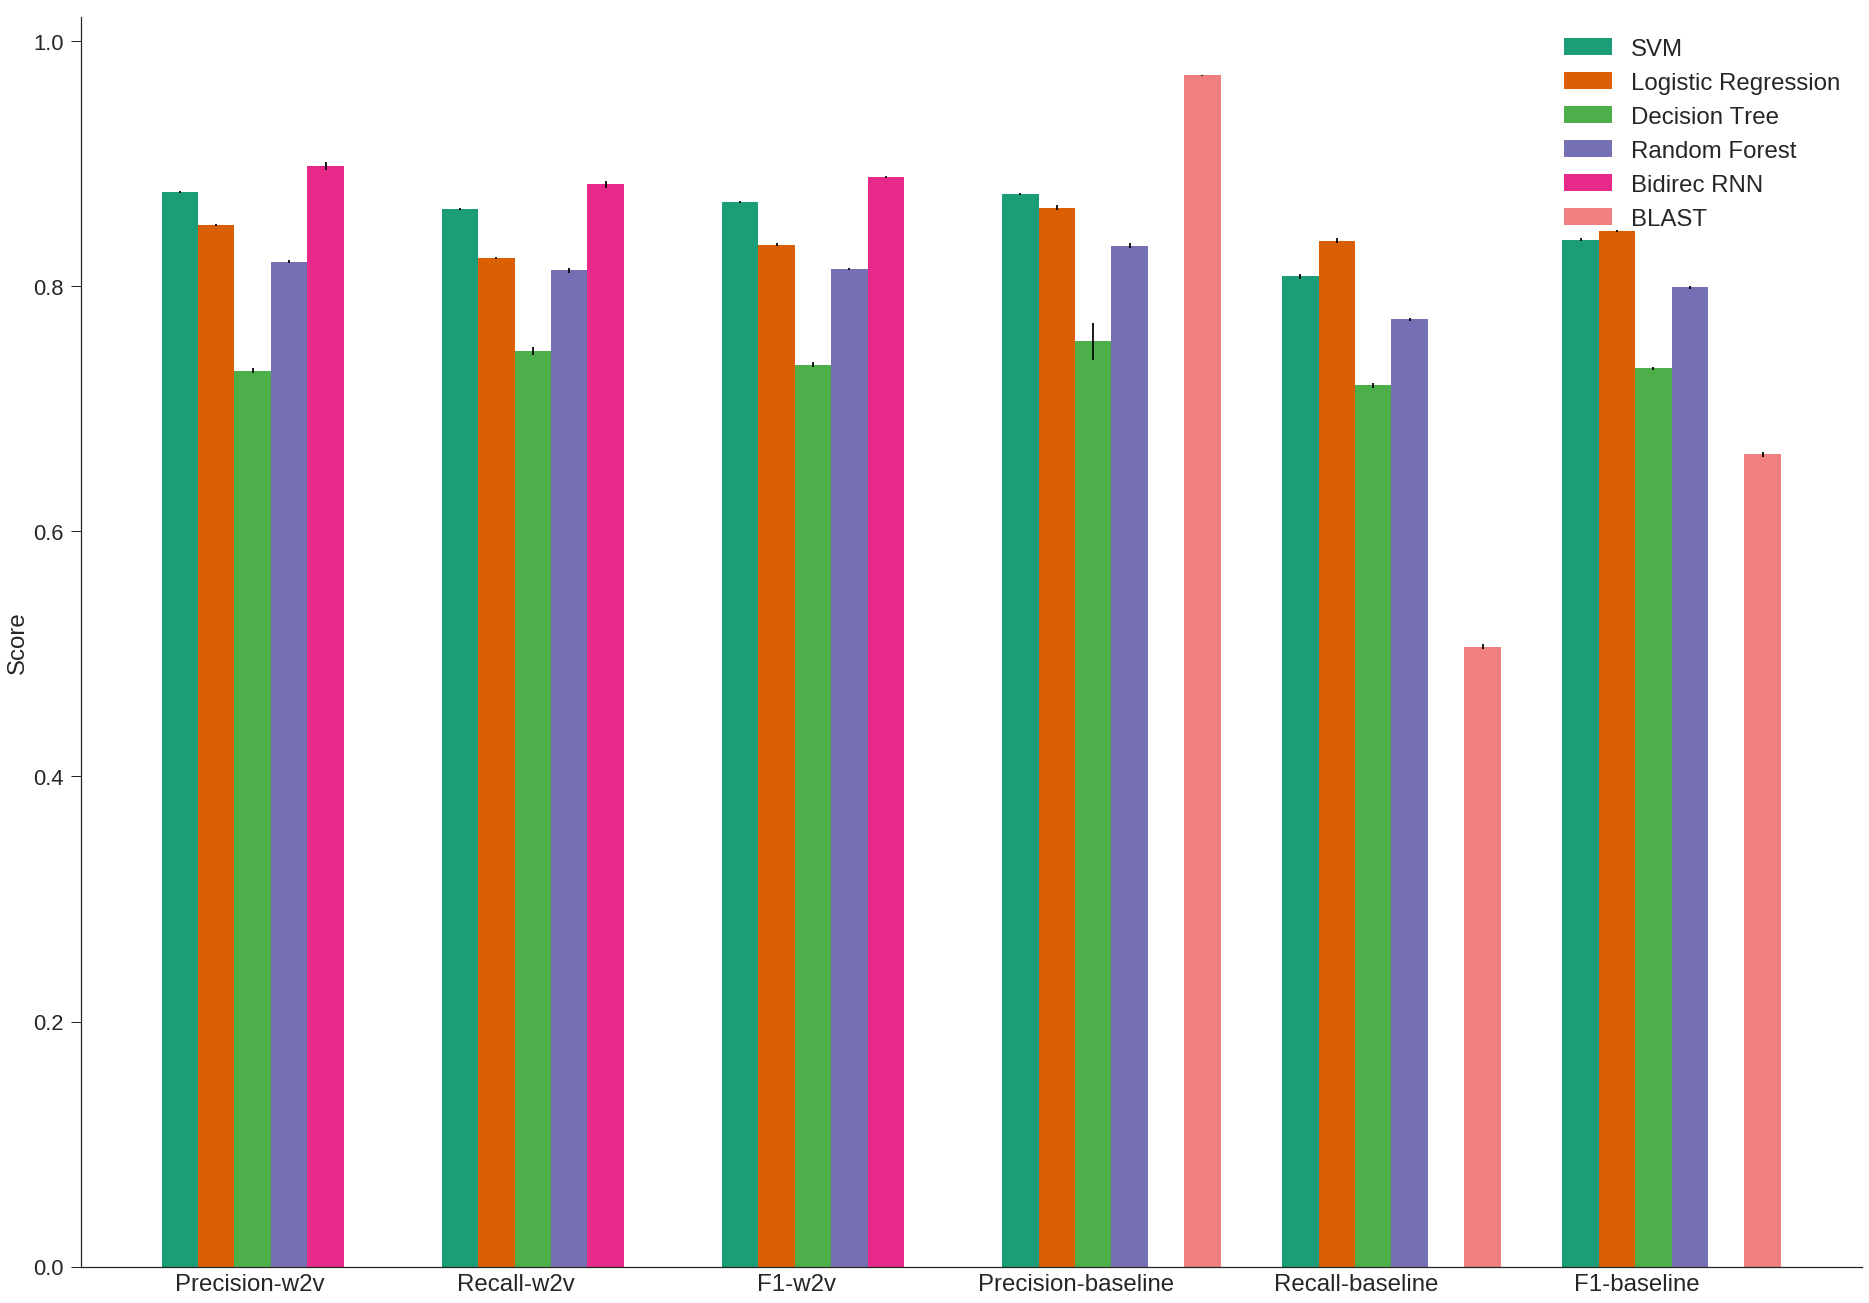

In [12]:
import seaborn as sns
sns.set_style("white")
mean_precision_w2v = [0.877, 0.85, 0.731, 0.82, 0.898]
mean_recall_w2v = [0.863, 0.823, 0.747, 0.813, 0.883]
mean_f1_w2v = [0.869, 0.834, 0.736, 0.814, 0.889]
mean_precision_kmer = [0.875, 0.864, 0.755, 0.833]
mean_recall_kmer = [0.808, 0.837, 0.719, 0.773]
mean_f1_kmer = [0.838, 0.846, 0.733, 0.799]

mean_svm = [0.877, 0.863, 0.869,0.875,0.808,0.838]
mean_logreg = [0.85, 0.823, 0.834,0.864, 0.837, 0.845]
mean_dt = [0.731, 0.747, 0.736,0.755, 0.719, 0.733]
mean_rf = [0.82, 0.813, 0.814,0.833, 0.773, 0.799]
mean_rnn = [0.898, 0.883, 0.889]
mean_blast = [0.972, 0.506, 0.663]


mean_svm_error = [0.001, 0.001, 0.0009, 0.001, 0.002, 0.001]
mean_logreg_error = [0.001, 0.001, 0.0009, 0.002, 0.002, 0.001]
mean_dt_error = [0.002, 0.003, 0.002, 0.015, 0.002, 0.001]
mean_rf_error = [0.001, 0.002, 0.001, 0.002, 0.001, 0.001]
mean_rnn_error = [0.003, 0.003, 0.001]
mean_blast_error = [0.0006, 0.002, 0.002]

plt.rc('ytick',labelsize=22)
plt.rc('xtick',labelsize=24)
algos = ['SVM', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Bidirec RNN', 'BLAST']
pos = list(range(len(mean_svm))) 
width = 0.13 

fig, ax = plt.subplots()
fig.set_size_inches(31.92, 23)
plt.tick_params(size = 10)
#plt.rc('xtick',labelsize=18)
plt.bar(pos, mean_svm, width, yerr = mean_svm_error, color = '#1b9e77')
plt.bar([p + width for p in pos], mean_logreg, width, yerr = mean_logreg_error, color = '#d95f02') 
plt.bar([p + 2*width for p in pos], mean_dt, width, yerr = mean_dt_error, color = '#4daf4a') 
plt.bar([p + 3*width for p in pos], mean_rf, width, yerr = mean_rf_error, color = '#7570b3') 
plt.bar([p + 4*width for p in list(range(3))], mean_rnn, width, yerr = mean_rnn_error, color = '#e7298a') 
plt.bar([p + 5*width for p in list(range(3,6))], mean_blast, width, yerr = mean_blast_error, color = 'lightcoral') 

# plt.scatter(pos, mean_svm_w2v,  s=90)
# plt.scatter([p + width for p in pos], mean_logreg_w2v, s=100) 
# plt.scatter([p + 2*width for p in pos], mean_dt_w2v, s=100) 
# plt.scatter([p + 3*width for p in pos], mean_rf_w2v,  s=100) 
# plt.scatter([p + 4*width for p in pos], mean_rnn_w2v,   s=100) 

# Set the y axis label
ax.set_ylabel('Score',fontsize = 24)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.tick_params(axis = 'x', size = 0)
plt.xticks([0.25,1.2,2.2,3.2,4.2,5.2], ('Precision-w2v', 'Recall-w2v', 'F1-w2v','Precision-baseline', 
                                        'Recall-baseline', 
                                        'F1-baseline'))
#plt.xticks()
# plt.bar([p + 5*width/2 for p in pos], mean_svm_kmer, width/2)
# plt.bar([p + 6*width/2 for p in pos], mean_logreg_kmer, width/2) 
# plt.bar([p + 7*width/2 for p in pos], mean_dt_kmer, width/2) 
# plt.bar([p + 8*width/2 for p in pos], mean_rf_kmer, width/2) 
# Set the chart's title
#ax.set_title('Test Subject Scores')

# Set the position of the x ticks
#ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
#ax.set_xticklabels(df['first_name'])

# Setting the x-axis and y-axis limits
#plt.xlim([0, 1.02])
plt.ylim(0.0,1.02)
#plt.ylim([0, max(df['pre_score'] + df['mid_score'] + df['post_score'])] )

# Adding the legend and showing the plot
plt.legend(algos, loc='upper right', fontsize = 24)
ax.figure.savefig('bar_all.eps', format = 'eps', dpi = 1200, bbox_inches="tight")
ax.figure.savefig('bar_all.png', format = 'png', dpi = 1200, bbox_inches="tight")
ax.figure.savefig('bar_all.pdf', format = 'pdf', dpi = 1200, bbox_inches="tight")
#plt.grid()
#plt.show()

## Creating cytoscape network file

In [190]:
result_handle = open("positive_bacteriocin_less_than_30_blast_result_agianst_itself.xml", 'r')
blast_records = NCBIXML.parse(result_handle)

out_handle = open('connections_file', 'w')
connections_dict = defaultdict(list)
for i, blast_record in enumerate(blast_records):
    for j, alignment in enumerate(blast_record.alignments): 
        for hsp in alignment.hsps:
            query_id = blast_record.query.split("|")[0]
            hit_id = alignment.hit_def.split("|")[0]
            query_id = '_'.join(query_id.split('.'))
            hit_id = '_'.join(hit_id.split('.'))
            if hsp.identities >= 35 and query_id != hit_id:
                #print (blast_record.query.split("|")[0])
                #print (alignment.hit_def.split("|")[0])
                connections_dict[query_id].append(hit_id)
                identity.append(hsp.identities)
                
                out_handle.write('%s %s\n' % (query_id, hit_id))
                #break

print (len(connections_dict))
out_handle.close()

185


In [33]:
# cluster_size_dict = defaultdict(list)
# for index, record in enumerate(SeqIO.parse('positive_bacteriocin_less_than_30.fa', 'fasta')):
#     tok = record.description.split('|')[0]
#     tok = '_'.join(tok.split('.'))
#     cluster_size_dict[tok] = 1
# print (len(cluster_size_dict))

346


In [206]:
cluster_dict = defaultdict(list)
#cluster_size_dict = defaultdict(int)
with open('connections_file', 'r') as in_handle:
    for line in in_handle:
        tok = line[0:-1].split(' ')
        #print (tok)
        if tok[1] not in cluster_dict[tok[0]] and tok[0] not in cluster_dict[tok[1]]:
            #cluster_size_dict[tok[0]] += 1
            cluster_dict[tok[0]].append(tok[1])
        #break
print (len(cluster_dict))

187


In [193]:
print (cluster_dict)

defaultdict(<class 'list'>, {'5_1': ['120_1'], '120_1': [], '6_1': ['119_1'], '119_1': [], '8_1': ['9_1'], '9_1': [], '10_1': ['130_1', '59_1'], '130_1': [], '59_1': ['130_1'], '11_1': ['96_1'], '96_1': [], '12_1': ['13_1', '14_1'], '13_1': ['14_1'], '14_1': ['100_1', '99_1'], '100_1': [], '99_1': ['100_1'], '17_1': ['40_1'], '40_1': [], '25_1': ['31_1', '128_1', '30_1'], '31_1': ['128_1'], '128_1': [], '30_1': ['128_1', '31_1'], '27_1': ['34_1'], '34_1': [], '28_1': ['29_1'], '29_1': [], '36_1': ['37_1'], '37_1': [], '39_1': ['173_2'], '173_2': [], '47_1': ['122_1'], '122_1': [], '49_1': ['17_2', '141_1'], '17_2': [], '141_1': [], '56_1': ['57_1'], '57_1': [], '58_1': ['125_1', '126_1', '108_1'], '125_1': ['126_1'], '126_1': [], '108_1': ['125_1', '126_1'], '60_1': ['153_2'], '153_2': [], '66_1': ['151_2'], '151_2': [], '68_1': ['70_1'], '70_1': [], '71_1': ['140_1', '87_1', '86_1', '139_1'], '140_1': [], '87_1': ['140_1', '139_1'], '86_1': ['87_1', '140_1', '139_1'], '139_1': ['140_1

In [204]:
cluster_dict_copy = defaultdict(list)
for key,val in cluster_dict.items():
    if val != []:
        cluster_dict_copy[key] = val
print (len(cluster_dict_copy))
print (cluster_dict_copy)

123
defaultdict(<class 'list'>, {'5_1': ['120_1'], '6_1': ['119_1'], '8_1': ['9_1'], '10_1': ['130_1', '59_1'], '59_1': ['130_1'], '11_1': ['96_1'], '12_1': ['13_1', '14_1'], '13_1': ['14_1'], '14_1': ['100_1', '99_1'], '99_1': ['100_1'], '17_1': ['40_1'], '25_1': ['31_1', '128_1', '30_1'], '31_1': ['128_1'], '30_1': ['128_1', '31_1'], '27_1': ['34_1'], '28_1': ['29_1'], '36_1': ['37_1'], '39_1': ['173_2'], '47_1': ['122_1'], '49_1': ['17_2', '141_1'], '56_1': ['57_1'], '58_1': ['125_1', '126_1', '108_1'], '125_1': ['126_1'], '108_1': ['125_1', '126_1'], '60_1': ['153_2'], '66_1': ['151_2'], '68_1': ['70_1'], '71_1': ['140_1', '87_1', '86_1', '139_1'], '87_1': ['140_1', '139_1'], '86_1': ['87_1', '140_1', '139_1'], '139_1': ['140_1'], '77_1': ['81_1', '78_1', '79_1', '107_1', '80_1'], '81_1': ['107_1'], '78_1': ['81_1', '79_1', '107_1', '80_1'], '79_1': ['81_1', '107_1', '80_1'], '80_1': ['81_1'], '89_1': ['189_2'], '90_1': ['188_2'], '92_1': ['93_1'], '94_1': ['109_1', '95_1', '103_1'

In [191]:
print (connections_dict)

defaultdict(<class 'list'>, {'5_1': ['120_1'], '6_1': ['119_1'], '8_1': ['9_1'], '9_1': ['8_1'], '10_1': ['130_1', '59_1'], '11_1': ['96_1'], '12_1': ['13_1', '14_1'], '13_1': ['12_1', '14_1'], '14_1': ['13_1', '12_1', '100_1', '99_1'], '17_1': ['40_1'], '25_1': ['31_1', '128_1', '30_1'], '27_1': ['34_1'], '28_1': ['29_1'], '29_1': ['28_1'], '30_1': ['128_1', '31_1', '25_1'], '31_1': ['25_1', '128_1', '30_1'], '34_1': ['27_1'], '36_1': ['37_1'], '37_1': ['36_1'], '39_1': ['173_2'], '40_1': ['17_1'], '47_1': ['122_1'], '49_1': ['17_2', '141_1'], '56_1': ['57_1'], '58_1': ['125_1', '126_1', '108_1'], '59_1': ['130_1', '10_1'], '60_1': ['153_2'], '66_1': ['151_2'], '68_1': ['70_1'], '70_1': ['68_1'], '71_1': ['140_1', '87_1', '86_1', '139_1'], '77_1': ['81_1', '78_1', '79_1', '107_1', '80_1'], '78_1': ['81_1', '77_1', '79_1', '107_1', '80_1'], '79_1': ['78_1', '81_1', '77_1', '107_1', '80_1'], '80_1': ['81_1', '78_1', '77_1', '79_1'], '81_1': ['78_1', '77_1', '79_1', '107_1', '80_1'], '86

In [239]:
cluster_sizes_dict = defaultdict(int)
print (cluster_sizes_dict)
seq_names = []
for key, values in connections_dict.items():
    if key not in seq_names:
        seq_names.append(key)
        cluster_sizes_dict[key] = 1 # 1 for the key itself in the cluster
        for val in values:
            if val not in seq_names:
                seq_names.append(val)
                print (key, val)
                cluster_sizes_dict[key] += 1
    elif key in seq_names: #key could have been in values previously
        for val in values:
            if val not in seq_names:
                flag = 0
                seq_names.append(val)
                for key_in, values_in in connections_dict.items():
                    for val_in in values_in:
                        if key == val_in:
                            cluster_sizes_dict[key_in] += 1
                            flag = 1 # added this node to a cluster
                            print ('hello')
                            print ('Previous', key, val)
                            break
                    if flag == 1:
                        break
            #cluster_sizes.append(len(cluster_dict_copy[key]) + 1)
print (len(cluster_sizes_dict))
count = 0
for key, val in cluster_sizes_dict.items():
    count = count + val
print (count)
print (len(set(seq_names)))
print (len(seq_names))
print (cluster_sizes_dict)
print (seq_names)

defaultdict(<class 'int'>, {})
5_1 120_1
6_1 119_1
8_1 9_1
10_1 130_1
10_1 59_1
11_1 96_1
12_1 13_1
12_1 14_1
hello
Previous 14_1 100_1
hello
Previous 14_1 99_1
17_1 40_1
25_1 31_1
25_1 128_1
25_1 30_1
27_1 34_1
28_1 29_1
36_1 37_1
39_1 173_2
47_1 122_1
49_1 17_2
49_1 141_1
56_1 57_1
58_1 125_1
58_1 126_1
58_1 108_1
60_1 153_2
66_1 151_2
68_1 70_1
71_1 140_1
71_1 87_1
71_1 86_1
71_1 139_1
77_1 81_1
77_1 78_1
77_1 79_1
77_1 107_1
77_1 80_1
89_1 189_2
90_1 188_2
92_1 93_1
94_1 109_1
94_1 95_1
94_1 103_1
94_1 102_1
94_1 106_1
94_1 105_1
94_1 104_1
97_1 131_1
150_1 151_1
153_1 158_1
153_1 235_2
154_1 155_1
1_2 217_2
10_2 11_2
15_2 111_2
15_2 22_2
15_2 16_2
15_2 98_2
18_2 27_2
18_2 224_2
18_2 222_2
23_2 212_2
23_2 211_2
24_2 69_2
24_2 68_2
28_2 39_2
28_2 40_2
30_2 33_2
30_2 31_2
30_2 32_2
30_2 196_2
30_2 200_2
30_2 202_2
34_2 36_2
34_2 37_2
34_2 35_2
42_2 43_2
42_2 44_2
42_2 201_2
45_2 91_2
45_2 215_2
46_2 93_2
49_2 85_2
51_2 208_2
51_2 60_2
56_2 57_2
56_2 166_2
56_2 163_2
56_2 167_2
56_2 2

In [241]:
for index, record in enumerate(SeqIO.parse('positive_bacteriocin_less_than_30.fa', 'fasta')): 
    tok = record.description.split('|')[0]
    tok = '_'.join(tok.split('.'))
    if tok not in seq_names:
        seq_names.append(tok)
        cluster_sizes_dict[tok] = 1
print (cluster_sizes_dict)

defaultdict(<class 'int'>, {'5_1': 2, '6_1': 2, '8_1': 2, '10_1': 3, '11_1': 2, '12_1': 5, '17_1': 2, '25_1': 4, '27_1': 2, '28_1': 2, '36_1': 2, '39_1': 2, '47_1': 2, '49_1': 3, '56_1': 2, '58_1': 4, '60_1': 2, '66_1': 2, '68_1': 2, '71_1': 5, '77_1': 6, '89_1': 2, '90_1': 2, '92_1': 2, '94_1': 8, '97_1': 2, '150_1': 2, '153_1': 3, '154_1': 2, '1_2': 2, '10_2': 2, '15_2': 5, '18_2': 4, '23_2': 3, '24_2': 5, '28_2': 3, '29_2': 1, '30_2': 8, '34_2': 4, '42_2': 4, '45_2': 3, '46_2': 2, '49_2': 2, '51_2': 4, '56_2': 17, '58_2': 2, '73_2': 2, '75_2': 2, '78_2': 3, '81_2': 2, '89_2': 2, '90_2': 2, '60_2': 1, '108_2': 2, '118_2': 2, '130_2': 3, '137_2': 4, '155_2': 2, '178_2': 2, '198_2': 2, '213_2': 2, '228_2': 2, '1_1': 1, '3_1': 1, '4_1': 1, '7_1': 1, '15_1': 1, '16_1': 1, '18_1': 1, '19_1': 1, '23_1': 1, '24_1': 1, '26_1': 1, '32_1': 1, '33_1': 1, '35_1': 1, '38_1': 1, '41_1': 1, '42_1': 1, '43_1': 1, '44_1': 1, '45_1': 1, '46_1': 1, '48_1': 1, '50_1': 1, '54_1': 1, '55_1': 1, '61_1': 1,

In [242]:
count = 0
for key, val in cluster_sizes_dict.items():
    count = count + val
print (count)

346


In [273]:
#print (cluster_dict)
seq_names_connections = [] 
connections_list_tuples = []
out_handle = open('connections_file_rectified', 'w')
for key, value in connections_dict.items():
    for target_node in value:
        if (target_node, key) not in connections_list_tuples:
            seq_names_connections.append(key)
            seq_names_connections.append(target_node)
            connections_list_tuples.append((key, target_node))
            print (key, target_node)
            out_handle.write('%s %s\n' % (key, target_node))
        
out_handle.close()
print (len(set(seq_names_connections)))
print (len(connections_list_tuples))
print ('done')       

5_1 120_1
6_1 119_1
8_1 9_1
10_1 130_1
10_1 59_1
11_1 96_1
12_1 13_1
12_1 14_1
13_1 14_1
14_1 100_1
14_1 99_1
17_1 40_1
25_1 31_1
25_1 128_1
25_1 30_1
27_1 34_1
28_1 29_1
30_1 128_1
30_1 31_1
31_1 128_1
36_1 37_1
39_1 173_2
47_1 122_1
49_1 17_2
49_1 141_1
56_1 57_1
58_1 125_1
58_1 126_1
58_1 108_1
59_1 130_1
60_1 153_2
66_1 151_2
68_1 70_1
71_1 140_1
71_1 87_1
71_1 86_1
71_1 139_1
77_1 81_1
77_1 78_1
77_1 79_1
77_1 107_1
77_1 80_1
78_1 81_1
78_1 79_1
78_1 107_1
78_1 80_1
79_1 81_1
79_1 107_1
79_1 80_1
80_1 81_1
81_1 107_1
86_1 87_1
86_1 140_1
86_1 139_1
87_1 140_1
87_1 139_1
89_1 189_2
90_1 188_2
92_1 93_1
94_1 109_1
94_1 95_1
94_1 103_1
94_1 102_1
94_1 106_1
94_1 105_1
94_1 104_1
95_1 109_1
95_1 103_1
95_1 102_1
95_1 106_1
95_1 105_1
95_1 104_1
97_1 131_1
99_1 100_1
102_1 106_1
102_1 103_1
102_1 105_1
102_1 104_1
102_1 109_1
103_1 106_1
103_1 105_1
103_1 109_1
103_1 104_1
104_1 105_1
104_1 106_1
104_1 109_1
105_1 106_1
105_1 109_1
106_1 109_1
108_1 125_1
108_1 126_1
125_1 126_1
139_1 

In [271]:
out_handle = open('connections_file_just_single', 'w')
for index, record in enumerate(SeqIO.parse('positive_bacteriocin_less_than_30.fa', 'fasta')): 
    tok = record.description.split('|')[0]
    tok = '_'.join(tok.split('.'))
    if tok not in set(seq_names_connections):
        seq_names_connections.append(tok)
        out_handle.write("%s  \n" % (tok))
out_handle.close()
print (len(set(seq_names_connections)))
print ("done")

346
done


In [66]:
colors = ['AliceBlue', 'AntiqueWhite', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque', 'BlanchedAlmond', 'Blue', 'BlueViolet', 'Brown', 'BurlyWood', 'CadetBlue', 'Chartreuse', 'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan', 'DarkBlue', 'DarkCyan', 'DarkGoldenRod', 'DarkGray', 'DarkGreen', 'DarkKhaki', 'DarkMagenta', 'DarkOliveGreen', 'DarkOrange', 'DarkOrchid', 'DarkRed', 'DarkSalmon', 'DarkSeaGreen', 'DarkSlateBlue', 'DarkSlateGray', 'DarkTurquoise', 'DarkViolet', 'DeepPink', 'DeepSkyBlue', 'DimGray', 'DodgerBlue', 'FireBrick', 'FloralWhite', 'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod', 'Gray', 'Green', 'GreenYellow', 'HoneyDew', 'HotPink', 'IndianRed', '', 'Indigo', '', 'Ivory', 'Khaki', 'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue', 'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGreen', 'LightPink',
         'LightSalmon', 'LightSeaGreen', 'LightSkyBlue', 'LightSlateGray', 'LightSteelBlue', 'LightYellow', 'Lime', 'LimeGreen', 'Linen', 'Magenta', 'Maroon', 'MediumAquaMarine', 'MediumBlue', 'MediumOrchid', 'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen', 'MediumTurquoise', 'MediumVioletRed', 'MidnightBlue', 'MintCream', 'MistyRose', 'Moccasin', 'NavajoWhite', 'Navy', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed', 'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed', 'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple', 'RebeccaPurple', 'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Salmon', 'SandyBrown', 'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue', 'SlateGray', 'Snow', 'SpringGreen', 'SteelBlue', 'Tan', 'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White', 'WhiteSmoke', 'Yellow', 'YellowGreen']

In [256]:
len(set(cluster_size_dict_list))
max(cluster_size_dict_list)

17

In [268]:
size_to_count_dict = defaultdict(int)
for key, value in cluster_sizes_dict.items():
    size_to_count_dict[value] += 1 
print (size_to_count_dict)

defaultdict(<class 'int'>, {2: 37, 3: 8, 5: 4, 4: 7, 6: 1, 8: 2, 1: 161, 17: 1})


In [292]:
size_to_count_dict_new = {2: 34, 3: 4, 5: 4, 4: 7, 6: 1, 7:1, 10:1, 8: 2, 1: 159, 20: 1}
count  = 0
for key, val in size_to_count_dict_new.items():
    count = count + ((key) * val)
print (count)

346


In [ ]:
out_handle = open('cluster_size_count.csv' , 'w')


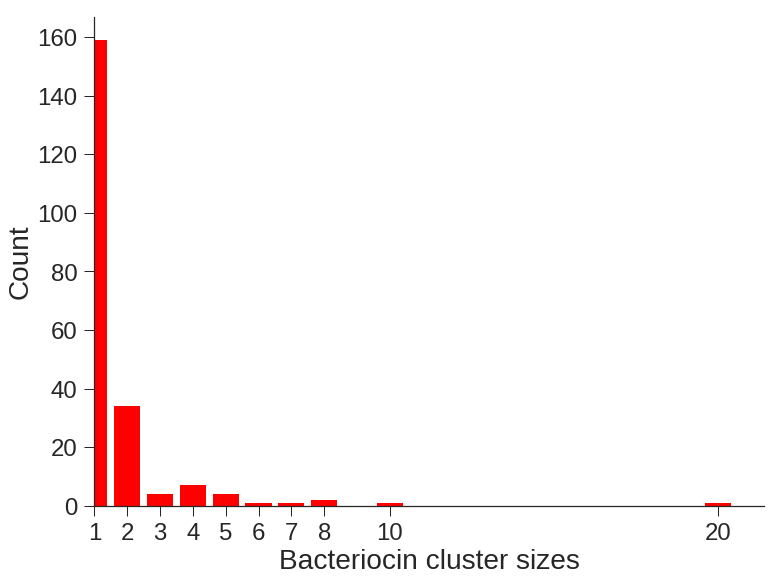

In [291]:
names = list(size_to_count_dict_new.keys())
values = list(size_to_count_dict_new.values())
x = sorted(names)
#print (names)
#print (values)
fig, axs = plt.subplots(1, 1, figsize=(12, 9))
axs.bar(names, values, color = 'r')
axs.set_ylabel('Count',fontsize = 28)
axs.set_xlabel('Bacteriocin cluster sizes',fontsize = 28)
axs.spines["top"].set_visible(False)  
axs.spines["right"].set_visible(False)
plt.xlim(1.0, )
plt.xticks(x, ('1', '2', '3', '4', '5', '6', '7', '8', '10', '20'))
plt.tick_params(size = 10)
#axs[1].scatter(names, values)
#axs[2].plot(names, values)
#fig.suptitle('Categorical Plotting')
ax.figure.savefig('bacteriocin_cluster_sizes.eps', format = 'eps', dpi = 1200, bbox_inches="tight")
ax.figure.savefig('bacteriocin_cluster_sizes.png', format = 'png', dpi = 1200, bbox_inches="tight")
ax.figure.savefig('bacteriocin_cluster_sizes.pdf', format = 'pdf', dpi = 1200, bbox_inches="tight")

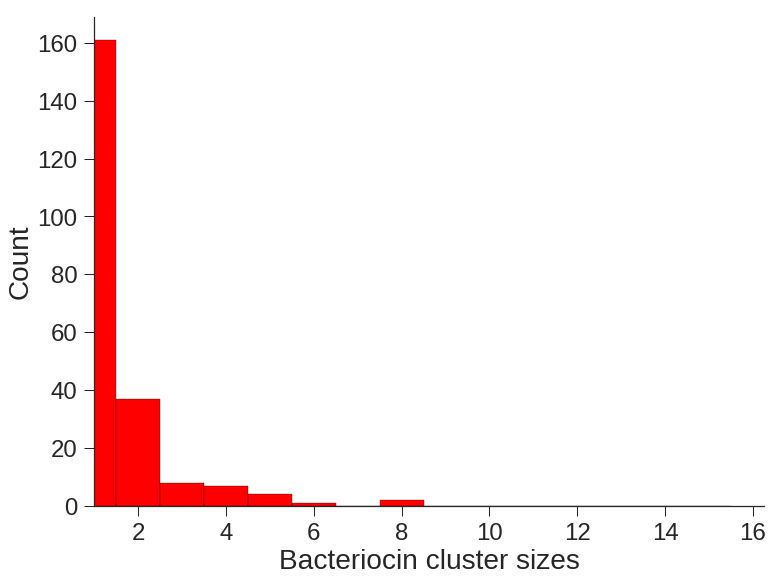

In [258]:
cluster_size_dict_list = [value for key, value in cluster_sizes_dict.items()]

plt.rc('ytick',labelsize=24)
plt.rc('xtick',labelsize=24)

_, ax = plt.subplots(1, 1, figsize=(12,9))
#fig.set_size_inches(12, 9)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.hist(cluster_size_dict_list, bins=np.arange(min(cluster_size_dict_list),max(cluster_size_dict_list)), 
                                               align='left', 
                                               color='r', edgecolor = 'black')
# plt.title("%i Negative bacteriocin sequences\nLengths %i to %i" \
#             % (len(sizes),min(sizes),max(sizes)))
ax.set_ylabel('Count',fontsize = 28)
ax.set_xlabel('Bacteriocin cluster sizes',fontsize = 28)
plt.xlim(1.0, )
plt.tick_params(size = 10)
#plt.xlabel("Sequence length")
#plt.ylabel("Count")
# ax.figure.savefig('bacteriocin_cluster_sizes.eps', format = 'eps', dpi = 1200, bbox_inches="tight")
# ax.figure.savefig('bacteriocin_cluster_sizes.png', format = 'png', dpi = 1200, bbox_inches="tight")
# ax.figure.savefig('bacteriocin_cluster_sizes.pdf', format = 'pdf', dpi = 1200, bbox_inches="tight")
#plt.show()